In [82]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf


np.set_printoptions(precision=3,suppress=True)

### 데이터셋의 경우 UCI Machine Learning Repository 에서 제공하는 auto-mpg 데이터를 활용하였다

In [83]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']
# 데이터가 null값으로 ?를 사용하고 있어 na_values옵션을 추가해주도록 하겠다
dataset = pd.read_csv(url, names = column_names,
                          na_values='?', comment= '\t',
                          sep = ' ', skipinitialspace=True)

In [84]:
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [85]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [86]:
# null값을 처리하는 방법에는 여러가지가 있으나 여기서는 간단히 지워주도록 하겠다
dataset = dataset.dropna()

In [87]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      0
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [88]:
# origin 컬럼은 국가를 나타내는 범주형 데이터이므로 원핫인코딩 처리를 해주도록 하겠다
dataset = pd.get_dummies(dataset, columns=['Origin'])
dataset.rename(columns={'Origin_1' : 'USA','Origin_2' : 'EU','Origin_3' : 'JP' }, inplace=True)
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,EU,JP
393,27.0,4,140.0,86.0,2790.0,15.6,82,1,0,0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0,1,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1,0,0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1,0,0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1,0,0


In [89]:
train_data = dataset.sample(frac=0.8, random_state=42)
test_data = dataset.drop(train_data.index)

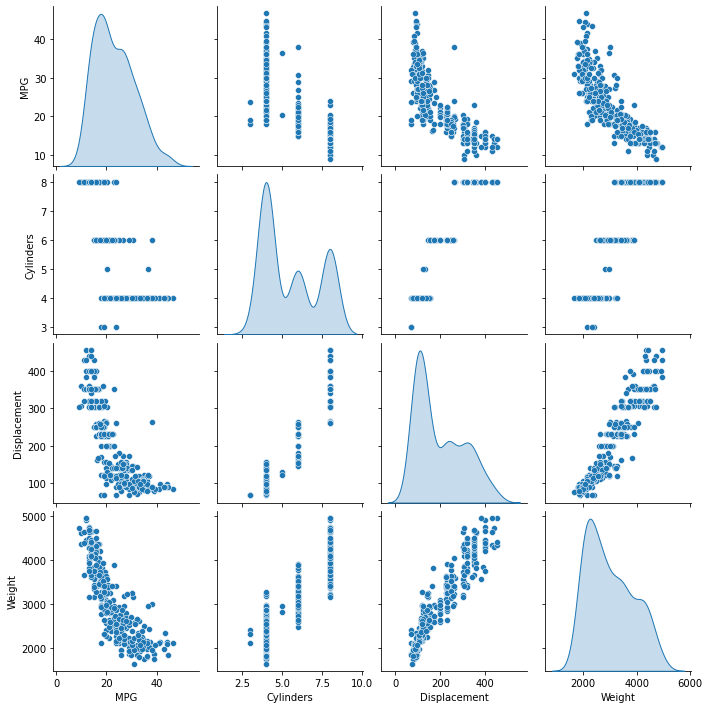

In [90]:
sns.pairplot(train_data[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')

In [91]:
train_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.153822,7.861854,9.0,17.000,22.0,28.075,46.6
Cylinders,314.0,5.531847,1.729449,3.0,4.000,4.0,8.000,8.0
Displacement,314.0,197.855096,106.501896,68.0,105.000,151.0,302.000,455.0
Horsepower,314.0,105.971338,39.636557,46.0,76.000,95.0,130.000,230.0
Weight,314.0,3005.745223,859.060925,1649.0,2231.000,2831.5,3641.750,4955.0
Acceleration,314.0,15.510828,2.803560,8.0,13.625,15.5,17.000,24.8
Model Year,314.0,75.910828,3.688989,70.0,73.000,76.0,79.000,82.0
USA,314.0,0.624204,0.485101,0.0,0.000,1.0,1.000,1.0
EU,314.0,0.171975,0.377961,0.0,0.000,0.0,0.000,1.0
JP,314.0,0.203822,0.403481,0.0,0.000,0.0,0.000,1.0


In [92]:
train_features = train_data.copy()
test_features = test_data.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

In [93]:
train_data.describe().transpose()[['mean','std']]

,mean,std
MPG,23.153822,7.861854
Cylinders,5.531847,1.729449
Displacement,197.855096,106.501896
Horsepower,105.971338,39.636557
Weight,3005.745223,859.060925
Acceleration,15.510828,2.803560
Model Year,75.910828,3.688989
USA,0.624204,0.485101
EU,0.171975,0.377961
JP,0.203822,0.403481


In [94]:
normalizer = tf.keras.layers.Normalization()
normalizer.adapt(np.array(train_features))

In [95]:
print(normalizer.mean.numpy())

[[   5.532  197.855  105.971 3005.746   15.511   75.911    0.624    0.172
     0.204]]


In [96]:
first = np.array(train_features[:1])
print('first ex : ',first)
print('Normalized : ',normalizer(first).numpy())

first ex :  [[   4.   96.   69. 2189.   18.   72.    0.    1.    0.]]
Normalized :  [[-0.887 -0.958 -0.934 -0.952  0.889 -1.062 -1.289  2.194 -0.506]]


In [97]:
horsepower = np.array(train_features['Horsepower'])

horsepower_normalizer = tf.keras.layers.Normalization(input_shape=[1,],axis=None)
horsepower_normalizer.adapt(horsepower)

In [98]:
horsepower_model = tf.keras.Sequential([
    horsepower_normalizer,
    tf.keras.layers.Dense(1)
])
horsepower_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_10 (Normaliza  (None, 1)                3         
 tion)                                                           
                                                                 
 dense_3 (Dense)             (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [99]:
horsepower_model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.1),
    loss = 'mean_absolute_error'
)

In [100]:
%%time
history = horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    epochs=100,
    verbose=0,
    validation_split = 0.2
)

CPU times: user 5.05 s, sys: 1.44 s, total: 6.49 s
Wall time: 4.01 s


In [101]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,3.904936,3.320525,95
96,3.906498,3.332387,96
97,3.904811,3.328057,97
98,3.910470,3.306448,98
99,3.905493,3.321376,99


In [102]:
def plot_loss(history):
  plt.plot(history.history['loss'],label='loss')
  plt.plot(history.history['val_loss'],label='val_loss')
  plt.ylim([0,10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()

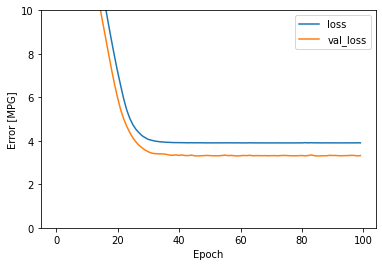

In [103]:
plot_loss(history)

In [104]:
test_rs = {}
test_rs['horsepower_model'] = horsepower_model.evaluate(
    test_features['Horsepower'],
    test_labels, verbose=0
)

In [105]:
x = tf.linspace(0,250,251)
y = horsepower_model.predict(x)

8/8 [==============================] - 0s 2ms/step


In [106]:
def plot_horsepower(x,y):
    plt.scatter(train_features['Horsepower'], train_labels, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel('Horsepower')
    plt.ylabel('MPG')
    plt.legend()

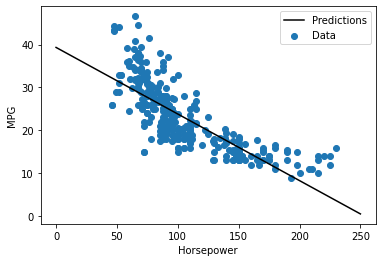

In [107]:
plot_horsepower(x,y)

## Linear regression with multiple inputs

In [108]:
linear_model = tf.keras.Sequential([
    normalizer,
    tf.keras.layers.Dense(1)
])

In [109]:
linear_model.predict(train_features[:5])

1/1 [==============================] - 0s 61ms/step


array([[-0.66 ],
       [-0.964],
       [ 2.67 ],
       [ 1.278],
       [ 1.836]], dtype=float32)

In [116]:
linear_model.layers[1].kernel, linear_model.layers[1].bias

(<tf.Variable 'dense_4/kernel:0' shape=(9, 1) dtype=float32, numpy=
 array([[-0.21 ],
        [ 0.17 ],
        [-0.595],
        [-0.568],
        [ 0.411],
        [ 0.667],
        [ 0.053],
        [-0.57 ],
        [ 0.235]], dtype=float32)>,
 <tf.Variable 'dense_4/bias:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>)

In [117]:
linear_model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.1),
    loss = 'mean_absolute_error'
)

In [118]:
%%time
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    verbose=0,
    validation_split = 0.2
)

CPU times: user 4.67 s, sys: 1.15 s, total: 5.82 s
Wall time: 3.73 s


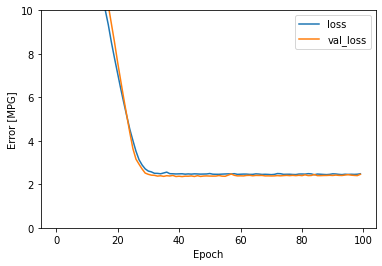

In [119]:
plot_loss(history)

In [124]:
test_rs['linear_model'] = linear_model.evaluate(
    test_features, test_labels,verbose =0
)